## 関数

scrape_race_id
レースの結果をスクレイピング

preprocessing(1)
データの整形(dateなし)

scrape_race_info
レースの情報をスクレイピング

preprocessing(2)
データの整形(dateあり)

split_data
時系列に沿ってデータを分割

# はじめに

In [17]:
import pandas as pd
import numpy as np
import datetime
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
import re
from urllib.request import urlopen

# 第1回：Pythonで競馬データをスクレイピングする

1:札幌　2:函館　3:福島　4:新潟　5:東京　6:中山　7:中京　8:京都　9:阪神　10:小倉

In [18]:
#競馬データスクレイピング

import pandas as pd
import time
#from tqdm import tqdm_notebook as tqdm
#現在ではインポートの仕方が下のように変わっています
from tqdm.notebook import tqdm

def scrape_race_results(race_id_list, pre_race_results={}):
    #race_results = pre_race_results
    race_results = pre_race_results.copy() #正しくはこちら。注意点で解説。
    for race_id in tqdm(race_id_list):
        if race_id in race_results.keys():
            continue
        try:
            time.sleep(1)
            url = "https://db.netkeiba.com/race/" + race_id
            race_results[race_id] = pd.read_html(url)[0]
        except IndexError:
            continue
#この部分は動画中に無いですが、捕捉できるエラーは拾った方が、エラーが出たときに分かりやすいです
            #except Exception as e:
            #print(e)
        #break
        #except:
        #break
    return race_results

#レースIDのリストを作る
race_id_list = []
for year in range(2020, 2021):
    #(2008,2021)
    for place in range(6, 7):
        #(1, 11)
        for kai in range(1, 2):
            #(1,6)
            for day in range(1, 2):
                #(1,13)
                for r in range(1, 13):
                    #(1,13)
                    race_id = str(year).zfill(4) + str(place).zfill(2) + str(kai).zfill(2) + str(day).zfill(2) + str(r).zfill(2)
                    race_id_list.append(race_id)

#スクレイピングしてデータを保存
test3 = scrape_race_results(race_id_list)
for key in test3: #.keys()は無くても大丈夫です
    test3[key].index = [key] * len(test3[key])
results = pd.concat([test3[key] for key in test3], sort=False) 
results.to_pickle('results.pickle')

  0%|          | 0/12 [00:00<?, ?it/s]

# 第2回・第3回 Pythonで競馬データを加工する

In [19]:
#データ整形
def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df["着順"].astype(str).str.contains("\D"))]
    df["着順"] = df["着順"].astype(int)

    # 性齢を性と年齢に分ける
    df["性"] = df["性齢"].map(lambda x: str(x)[0])
    df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
    df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df["単勝"] = df["単勝"].astype(float)

    # 不要な列を削除
    df.drop(["タイム", "着差", "調教師", "性齢", "馬体重"], axis=1, inplace=True)

    return df

In [20]:
results = preprocessing(results)

In [21]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, 202006010101 to 202006010112
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   着順      184 non-null    int32  
 1   枠番      184 non-null    int64  
 2   馬番      184 non-null    int64  
 3   馬名      184 non-null    object 
 4   斤量      184 non-null    float64
 5   騎手      184 non-null    object 
 6   単勝      184 non-null    float64
 7   人気      184 non-null    int64  
 8   性       184 non-null    object 
 9   年齢      184 non-null    int32  
 10  体重      184 non-null    int32  
 11  体重変化    184 non-null    int32  
dtypes: float64(2), int32(4), int64(3), object(3)
memory usage: 15.8+ KB


# 第4回 ロジスティック回帰で競馬予想してみた

In [22]:
#4着以下を全て4にする
clip_rank = lambda x: x if x < 4 else 4
#動画中のresultsは、preprocessing関数で前処理が行われた後のデータ
results["rank"] = results["着順"].map(clip_rank)
results.drop(["着順", "馬名"], axis=1, inplace=True)

#カテゴリ変数をダミー変数化
results_d = pd.get_dummies(results)

#訓練データとテストデータに分ける
from sklearn.model_selection import train_test_split

X = results_d.drop(["rank"], axis=1)
y = results_d["rank"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=0
)

#アンダーサンプリング
from imblearn.under_sampling import RandomUnderSampler

rank_1 = y_train.value_counts()[1]
rank_2 = y_train.value_counts()[2]
rank_3 = y_train.value_counts()[3]

rus = RandomUnderSampler(
    #ratio={1: rank_1, 2: rank_2, 3: rank_3, 4: rank_1},
    sampling_strategy={1: rank_1, 2: rank_2, 3: rank_3, 4: rank_1},
    random_state=71
)

#X_train_rus, y_train_rus = rus.fit_sample(X_train.values, y_train.values)
X_train_rus, y_train_rus = rus.fit_resample(X_train.values, y_train.values)

#訓練
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_rus, y_train_rus)

#スコアを表示
print(model.score(X_train, y_train), model.score(X_test, y_test))

#予測結果を確認
y_pred = model.predict(X_test)
pred_df = pd.DataFrame({"pred": y_pred, "actual": y_test})
pred_df[pred_df["pred"] == 1]["actual"].value_counts()

#回帰係数の確認
coefs = pd.Series(model.coef_[0], index=X.columns).sort_values()
coefs[["枠番", "馬番", "斤量", "単勝", "人気", "年齢", "体重", "体重変化"]]

0.5 0.3392857142857143


C:\Users\81906\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


枠番     -0.048241
馬番     -0.284798
斤量      0.147767
単勝     -0.149205
人気     -0.170903
年齢      0.047113
体重     -0.010991
体重変化    0.527144
dtype: float64

注意点

In [23]:
results = pd.read_pickle('results.pickle')
results = preprocessing(results)

In [24]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, 202006010101 to 202006010112
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   着順      184 non-null    int32  
 1   枠番      184 non-null    int64  
 2   馬番      184 non-null    int64  
 3   馬名      184 non-null    object 
 4   斤量      184 non-null    float64
 5   騎手      184 non-null    object 
 6   単勝      184 non-null    float64
 7   人気      184 non-null    int64  
 8   性       184 non-null    object 
 9   年齢      184 non-null    int32  
 10  体重      184 non-null    int32  
 11  体重変化    184 non-null    int32  
dtypes: float64(2), int32(4), int64(3), object(3)
memory usage: 15.8+ KB


# 第5回 BeautifulSoupで競馬データを取得する

In [25]:
#BSを使って
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
import re
import datetime

def scrape_race_info(race_id_list):
    race_infos = {}
    for race_id in tqdm(race_id_list):
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")

            texts = (
                soup.find("div", attrs={"class": "data_intro"}).find_all("p")[0].text
                + soup.find("div", attrs={"class": "data_intro"}).find_all("p")[1].text
            )
            info = re.findall(r"\w+", texts)
            info_dict = {}
            for text in info:
                if text in ["芝", "ダート"]:
                    info_dict["race_type"] = text
                if "障" in text:
                    info_dict["race_type"] = "障害"
                if "m" in text:
                    info_dict["course_len"] = int(re.findall(r"\d+", text)[0])
                if text in ["良", "稍重", "重", "不良"]:
                    info_dict["ground_state"] = text
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    info_dict["weather"] = text
                if "年" in text:
                    info_dict["date"] = text
            race_infos[race_id] = info_dict
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return race_infos

#前回保存したpickleファイルからデータ取得
results = pd.read_pickle('results.pickle')

#レースID一覧を取得してスクレイピング
race_id_list = results.index.unique()
race_infos = scrape_race_info(race_id_list)

#DataFrame型にする
race_infos = pd.DataFrame(race_infos).T

#resultsに結合
results_addinfo = results.merge(race_infos, left_index=True, right_index=True, how="inner")

#date列の処理を追加
def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df["着順"].astype(str).str.contains("\D"))]
    df["着順"] = df["着順"].astype(int)

    # 性齢を性と年齢に分ける
    df["性"] = df["性齢"].map(lambda x: str(x)[0])
    df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
    df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df["単勝"] = df["単勝"].astype(float)

    # 不要な列を削除
    df.drop(["タイム", "着差", "調教師", "性齢", "馬体重"], axis=1, inplace=True)
    
    df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")

    return df

#前処理
results_p = preprocessing(results_addinfo)

#時系列に沿ってデータを分割
def split_data(df, test_size):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test

results_p.drop(["馬名"], axis=1, inplace=True)
results_d = pd.get_dummies(results_p)
results_d["rank"] = results_d["着順"].map(lambda x: x if x < 4 else 4)
train, test = split_data(results_d, test_size=0.3)
X_train = train.drop(["着順", "date", "rank"], axis=1)
y_train = train["rank"]
X_test = test.drop(["着順", "date", "rank"], axis=1)
y_test = test["rank"]

#アンダーサンプリング
from imblearn.under_sampling import RandomUnderSampler

rank_1 = train["rank"].value_counts()[1]
rank_2 = train["rank"].value_counts()[2]
rank_3 = train["rank"].value_counts()[3]
rus = RandomUnderSampler(
    sampling_strategy={1: rank_1, 2: rank_2, 3: rank_3, 4: rank_1}, random_state=71
)

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
#fit_sample -> fit_resample

#ランダムフォレストによる予測
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_rus, y_train_rus)
print(clf.score(X_train, y_train), clf.score(X_test, y_test))

  0%|          | 0/12 [00:00<?, ?it/s]

0.6456692913385826 0.3157894736842105


In [28]:
results_p

,着順,枠番,馬番,斤量,騎手,単勝,人気,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化
202006010101,1,4,7,54.0,伊藤工真,3.6,2,1200,晴,ダート,良,2020-01-05,牝,3,460,2
202006010101,2,1,1,54.0,柴田善臣,17.2,5,1200,晴,ダート,良,2020-01-05,牝,3,432,4
202006010101,3,2,3,54.0,岩部純二,199.0,12,1200,晴,ダート,良,2020-01-05,牝,3,458,0
202006010101,4,3,6,54.0,武士沢友,50.4,8,1200,晴,ダート,良,2020-01-05,牝,3,418,0
202006010101,5,6,12,54.0,マーフィ,1.6,1,1200,晴,ダート,良,2020-01-05,牝,3,536,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202006010112,12,2,4,55.0,フォーリ,4.9,2,1200,晴,芝,良,2020-01-05,牝,6,450,-6
202006010112,13,1,1,57.0,内田博幸,54.7,12,1200,晴,芝,良,2020-01-05,牡,5,498,14
202006010112,14,6,11,54.0,藤岡康太,111.6,15,1200,晴,芝,良,2020-01-05,牝,4,476,20
202006010112,15,2,3,57.0,木幡巧也,120.0,16,1200,晴,芝,良,2020-01-05,セ,6,450,14


# 第6回 lightgbm・ランダムフォレストで競馬予想

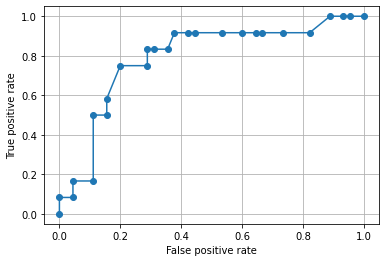

0.5
0.5
0.9963592233009708
0.7148148148148149


,features,importance
1,馬番,49
3,単勝,46
4,人気,34
7,体重変化,25
0,枠番,24
5,年齢,21
6,体重,16
65,性_牝,12
57,course_len_1200,7
2,斤量,4


In [29]:
#上で保存したpickleファイルの読み込み
#results = pd.read_pickle('results.pickle')

#前処理
#results_p = preprocessing(results)

#着順を0or1にする
#results_p['rank'] = results_p['着順'].map(lambda x: 1 if x<4 else 0)
#results_p.drop(['着順'], axis=1, inplace=True)
#↑このコード実行するとエラーはくよ(着順が落ちるから)

#もし、動画のように着順をdropしてrankを作っている場合は
#results_p['rank'] = results_p['rank'].map(lambda x: 1 if x<4 else 0)

#y_testデータを今までは[1-4]の表記をしていたがlightgbm or ランダムフォレストでやるときは[0,1]の表記にしないといけないそのための変換コード
#y_train = y_train.map(lambda x: 1 if x<4 else 0)
#y_test = y_test.map(lambda x: 1 if x<4 else 0)


results_d = pd.get_dummies(results_p)
results_d["rank"] = results_d["着順"].map(lambda x: 1 if x < 4 else 0)
train, test = split_data(results_d, test_size=0.3)
X_train = train.drop(["着順", "date", "rank"], axis=1)
y_train = train["rank"]
X_test = test.drop(["着順", "date", "rank"], axis=1)
y_test = test["rank"]

#ランダムフォレストによる予測モデル作成
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=100)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:, 1]

#ROC曲線の表示
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#jupyterlabを使う場合、この2行はいらない
#from jupyterthemes import jtplot
#jtplot.style(theme="monokai")

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker="o")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.grid()
plt.show()

#AUCスコアの表示
roc_auc_score(y_test, y_pred)
y_pred_train = rf.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred_train)

#パラメータの調整
params = {
    "min_samples_split": 500,
    "max_depth": None,
    "n_estimators": 60,
    "criterion": "entropy",
    "class_weight": "balanced",
    "random_state": 100,
}
rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred_train = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

#変数の重要度の表示
importances = pd.DataFrame(
    {"features": X_train.columns, "importance": rf.feature_importances_}
)
importances.sort_values("importance", ascending=False)[:20]

#LightGBMによる予測モデル作成
import lightgbm as lgb

params = {
    "num_leaves": 4,
    "n_estimators": 80,
    #'min_data_in_leaf': 15,
    "class_weight": "balanced",
    "random_state": 100,
}
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

#変数の重要度の表示
importances = pd.DataFrame(
    {"features": X_train.columns, "importance": lgb_clf.feature_importances_}
)
importances.sort_values("importance", ascending=False)[:20]

# 第7回 Pythonで過去成績データをスクレイピングする

## scrape_race_results関数

In [12]:
def scrape_race_results(race_id_list):   
    #race_idをkeyにしてDataFrame型を格納
    race_results = {}
    for race_id in tqdm(race_id_list):
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            time.sleep(1)
	    #メインとなるテーブルデータを取得
            df = pd.read_html(url)[0]
            
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")
            
            #馬ID、騎手IDをスクレイピング
            horse_id_list = []
            horse_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                "a", attrs={"href": re.compile("^/horse")}
            )
            for a in horse_a_list:
                horse_id = re.findall(r"\d+", a["href"])
                horse_id_list.append(horse_id[0])
            jockey_id_list = []
            jockey_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                "a", attrs={"href": re.compile("^/jockey")}
            )
            for a in jockey_a_list:
                jockey_id = re.findall(r"\d+", a["href"])
                jockey_id_list.append(jockey_id[0])
            df["horse_id"] = horse_id_list
            df["jockey_id"] = jockey_id_list
            
            race_results[race_id] = df
	#存在しないrace_idを飛ばす
        except IndexError:
            continue
	#wifiの接続が切れた時などでも途中までのデータを返せるようにする
        except Exception as e:
            print(e)
            break
	#Jupyterで停止ボタンを押した時の対処    
        except:
            break
    
    return race_results

In [13]:
#スクレイピング実行
race_results = scrape_race_results(race_id_list)

#indexをrace_idにする
for key in race_results:
    race_results[key].index = [key] * len(race_results[key])

#pd.DataFrame型にして一つのデータにまとめる
race_results_df = pd.concat([race_results[key] for key in race_results])

#race_infosをmerge
results = race_results_df.merge(race_infos, left_index=True,
    right_index=True, how='left')
    
#pickleファイルに保存
results.to_pickle('results.pickle')

  0%|          | 0/12 [00:00<?, ?it/s]

## scrape_horse_results関数

In [14]:
def scrape_horse_results(horse_id_list):
    #horse_idをkeyにしてDataFrame型を格納
    horse_results = {}
    for horse_id in tqdm(horse_id_list):
        try:
            url = 'https://db.netkeiba.com/horse/' + horse_id
            df = pd.read_html(url)[3]
	    #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
            if df.columns[0]=='受賞歴':
                df = pd.read_html(url)[4]
            horse_results[horse_id] = df
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    
    return horse_results

In [15]:
###インデックスをhorse_idにする
for key in horse_results:
    horse_results[key].index = [key] * len(horse_results[key])
    
#一つのDataFrame型のデータにまとめる。
horse_results = pd.concat([horse_results[key] for key in horse_results])

#pickleファイルに保存
horse_results.to_pickle('horse_results.pickle')

NameError: name 'horse_results' is not defined

# 第8回 競馬予想AIで学ぶクラス定義・オブジェクト志向

## HorseResultsクラス

In [ ]:
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金']]
        self.preprocessing()
        self.horse_results.rename(columns={'着順':'着順_ave', '賞金':'賞金_ave'}, 
	inplace=True)
        
    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)

        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
    
        self.horse_results = df
        
    def average(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        return target_df[target_df['date']<date].groupby(level=0)[['着順_ave', '賞金_ave']].mean()
    
    def merge(self, results, date):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date), left_on='horse_id',
                             right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date) for date in tqdm(date_list)])
        return merged_df

# 第9回 データ加工で競馬予想AIの精度を上げる

## HorseResultsクラス

In [ ]:
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金']]
        self.preprocessing()
        
    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)

        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        #賞金のNaNを0で埋める
        df['賞金'].fillna(0, inplace=True)
    
        self.horse_results = df
        
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.loc[horse_id_list]
        
        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].\
                sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
            
        average = filtered_df.groupby(level=0)[['着順', '賞金']].mean()
        return average.rename(columns={'着順':'着順_{}R'.format(n_samples), '賞金':'賞金_{}R'.format(n_samples)})
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id',
                             right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

#HorseResultsクラスを使って過去成績データを結合
hr = HorseResults(horse_results)
results_5R = hr.merge_all(results_p, n_samples=5)
results_5R['rank'] = results_5R['着順'].map(lambda x: 1 if x<4 else 0)
results_5R.drop(['着順', '騎手', 'horse_id', '馬名'], axis=1, inplace=True)
results_d = pd.get_dummies(results_5R)

#訓練データとテストデータに分ける
train, test = split_data(results_d)
X_train = train.drop(['rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank'], axis=1)
y_test = test['rank']

#LightGBMで学習
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

params = {
    "num_leaves": 4,
    "n_estimators": 80,
    #'min_data_in_leaf': 15,
    "class_weight": "balanced",
    "random_state": 100,
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

#変数の重要度を出力
importances = pd.DataFrame(
    {"features": X_train.columns, "importance": lgb_clf.feature_importances_}
)
importances.sort_values("importance", ascending=False)[:20] #jupyterで出力

# 第10回 競馬予想AIの回収率をシミュレーションする方法

## scrape_return_tables関数

In [ ]:
def scrape_return_tables(race_id_list, pre_return_rables={}):
    return_tables = pre_return_tables
    for race_id in tqdm(race_id_list):
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            
            #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
            #そのため、改行コードを文字列brに変換して後でsplitする
            f = urlopen(url)
            html = f.read()
            html = html.replace(b'<br />', b'br')
            dfs = pd.read_html(html)

            #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
            df = pd.concat([dfs[1], dfs[2]])

            df.index = [race_id] * len(df)
            return_tables[race_id] = df
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e: #捕捉できるエラーは原因がわかるようにprintしてからbreak
            print(e)
            break
        except:
            break
    return return_tables

## Returnクラス

In [ ]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1,2]]
        #wins = fukusho[1].str.split('br', expand=True).drop([3], axis=1)
        #5列できてしまう場合があるので、現在はこちらを推奨
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        
        wins.columns = ['win_0', 'win_1', 'win_2']
        #returns = fukusho[2].str.split('br', expand=True).drop([3], axis=1)
        #5列できてしまう場合があるので、現在はこちらを推奨
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
        return df.fillna(0).astype(int)

## ModelEvaluatorクラス

In [ ]:
class ModelEvaluator:
    def __init__(self, model, return_tables):
        self.model = model
        self.fukusho = Return(return_tables).fukusho
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)[:, 1]
    
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features": X.columns, 
                                    "importance": self.model.feature_importances_})
        return importances.sort_values("importance", ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番']]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1]['馬番']
        else:
            return pred_table
        
    def calculate_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        money = -100 * len(pred_table)
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return money

## シミュレーション実行

In [ ]:
gain = {}
n_samples = 100
for i in tqdm(range(n_samples)):
    threshold = i / n_samples
    gain[threshold] = me.calculate_return(X_test, threshold)
    
#プロット
pd.Series(gain).plot()

## 注意点

In [ ]:
for key in return_tables.keys():
    return_tables[key].index = [key]*len(return_tables[key])
    
return_tables = pd.concat([return_tables[key] for key in return_tables.keys()])

# 第11回 Pythonで過去成績を入れた出馬表を作る方法

In [ ]:
import time
import re

class ShutubaTable:
    def __init__(self):
        self.shutuba_table = pd.DataFrame()
    
    def scrape_shutuba_table(self, race_id_list):
        options = ChromeOptions()
        driver = Chrome(options=options)
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            driver.get(url)
            elements = driver.find_elements_by_class_name('HorseList')
            for element in elements:
                tds = element.find_elements_by_tag_name('td')
                row = []
                for td in tds:
                    row.append(td.text)
                    if td.get_attribute('class') in ['HorseInfo', 'Jockey']:
                        href = td.find_element_by_tag_name('a').get_attribute('href')
                        row.append(re.findall(r'\d+', href)[0])
                self.shutuba_table = self.shutuba_table.append(pd.Series(row, name=race_id))
            time.sleep(1)
        driver.close()
        
    def preprocessing(self):
        df = self.shutuba_table.copy()
        df = df[[0,1,3,4,5,6,7,8,10,11,12]]
        df.columns = ['枠番', '馬番', '馬名', 'horse_id', '性齢', '斤量', '騎手', 'jockey_id',
                      '馬体重', '単勝', '人気']
        self.shutuba_table = df
        
    def merge_horse_results(self, horse_results, columns, n_race=5):
        for column in columns:
            df = horse_results.groupby(level=0).head(n_race)
            df = df.astype(str).groupby(level=0)[column].apply(lambda x: ','.join(x))
            df = df.str.split(',', expand=True).add_prefix('{}_'.format(column))
            self.shutuba_table = self.shutuba_table.merge(df, left_on='horse_id',
                                                          right_index=True, how='left')

# 第12回 LightGBMに競馬の血統データを入れる方法

scrape_peds関数

In [ ]:
def scrape_peds(horse_id_list, pre_peds = {}):
    peds = pre_peds
    for horse_id in tqdm(horse_id_list):
        try:
            url = "https://db.netkeiba.com/horse/ped/" + horse_id
            df = pd.read_html(url)[0]

            #重複を削除して1列のSeries型データに直す
            generations = {}
            for i in reversed(range(5)):
                generations[i] = df[i]
                df.drop([i], axis=1, inplace=True)
                df = df.drop_duplicates()
            ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)

            peds[horse_id] = ped.reset_index(drop=True)
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return peds

注意点

In [ ]:
for key in peds:
    return_tables[key].index = [key]*len(return_tables[key])
    
peds = pd.concat([peds[key] for key in peds])

処理実行

In [ ]:
#データ読み込み&前処理
results = pd.read_pickle('results.pickle')
horse_results = pd.read_pickle('horse_results.pickle')
results_p = preprocessing(results)
hr = HorseResults(horse_results)
results_m = hr.merge_all(results_p, n_samples=5)
results_m['rank'] = results_m['着順'].map(lambda x:1 if x<4 else 0)
results_m.drop(['着順'], axis=1, inplace=True)

#horse_idをラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
results_m['horse_id'] = LabelEncoder().fit_transform(results_m['horse_id'])

#ダミー変数化
results_d = pd.get_dummies(results_m)

#horse_idをpandasのcategory型に変換
results_d['horse_id'] = results_d['horse_id'].astype('category')

#LightGBMで学習
import lightgbm as lgb

train, test = split_data(results_d)
X_train = train.drop(['rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank'], axis=1)
y_test = test['rank']
params = {
    "num_leaves": 4,
    "n_estimators": 80,
    "class_weight": "balanced",
    "random_state": 100,
}
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

#特徴量の重要度を表示
return_tables = pd.read_pickle('return_tables.pickle')
me = ModelEvaluator(lgb_clf, return_tables)
me.feature_importance(X_test)

# 第13回 競馬予想AIの回収率を上げた意外な方法とは？

process_categorical関数

In [ ]:
def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
    
    #target_columns以外にカテゴリ変数があれば、ダミー変数にする
    df2 = pd.get_dummies(df2)
    
    for column in target_columns:
        df2[column] = df2[column].astype('category')
    
    return df2

In [ ]:
categorical_columns = ['horse_id'] + peds.columns
results_d = process_categorical(results_m, categorical_columns)

gain関数

In [ ]:
def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = 1 * i / n_samples + min_threshold * (1-(i/n_samples))
        n_bets, money = return_func(X, threshold)
        if n_bets > lower:
            gain[n_bets] = (n_bets*100 + money) / (n_bets*100)
    return pd.Series(gain)

Returnクラス

In [ ]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1,2]]
        #wins = fukusho[1].str.split('br', expand=True).drop([3], axis=1)
        #5列できてしまう場合があるので、現在はこちらを推奨
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        
        wins.columns = ['win_0', 'win_1', 'win_2']
        #returns = fukusho[2].str.split('br', expand=True).drop([3], axis=1)
        #5列できてしまう場合があるので、現在はこちらを推奨
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
        return df.fillna(0).astype(int)

    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0]=='単勝'][[1,2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
            
        return tansho

ModelEvaluatorクラス

In [ ]:
class ModelEvaluator:
    def __init__(self, model, return_tables):
        self.model = model
        self.fukusho = Return(return_tables).fukusho
        self.tansho = Return(return_tables).tansho
    
    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        return proba
    
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features": X.columns, 
                                    "importance": self.model.feature_importances_})
        return importances.sort_values("importance", ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番']]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1]['馬番']
        else:
            return pred_table
        
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return n_bets, money
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        money += df[df['win']==df['馬番']]['return'].sum()
        return n_bets, money    